# Linear Models
## Dream Team - ORIE 4741 Project

In [1]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random, Lasso, MLBase
# LassoPlot is not working with the other updated packages

In [2]:
include("../plot_pred.jl")

plot_pred_true (generic function with 2 methods)

Load data from CSV.

In [3]:
df = CSV.read("../data collection/weekly_ff.csv", DataFrame)
# df = DataFrame(load("weekly_ff.csv"))

feature_names = names(df)
for i in 1:56
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Int64
6	PassingTD			Int64
7	Int			Int64
8	PassingAtt			Int64
9	Cmp			Int64
10	RushingAtt			Int64
11	RushingYds			Int64
12	RushingTD			Int64
13	Rec			Int64
14	Tgt			Int64
15	ReceivingYds			Int64
16	ReceivingTD			Int64
17	FL			Int64
18	PPRFantasyPoints			Float64
19	StandardFantasyPoints			Float64
20	HalfPPRFantasyPoints			Float64
21	type			String
22	game_id			Int64
23	team2			String
24	season			Int64
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_cum			Float64
36	Tgt_cum			Float64
37	ReceivingYds_cum			Float64
38	ReceivingTD_cum			Float64
39	FL_cum			Float64
40	team1_score_cum			Float64
41	team2_score_cum			Float64
42	PassingYds_prev			Int64
43	PassingTD_prev			Int64
44	Int_prev			Int64
45	PassingAt

Train/test split with proportion of training data = 0.8

In [4]:
Random.seed!(0)

df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = target[1:ntrain, :StandardFantasyPoints]
test_std = target[ntrain:end, :StandardFantasyPoints]

train_ppr = target[1:ntrain, :PPRFantasyPoints]
test_ppr = target[ntrain:end, :PPRFantasyPoints]

train_half = target[1:ntrain, :HalfPPRFantasyPoints]
test_half = target[ntrain:end, :HalfPPRFantasyPoints]

# let's take a look
train_x

Size of dataset: 52744


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,13,Daryl Richardson,RB,STL,0,0,0,0
2,13,Bennie Fowler,WR,DEN,0,0,0,0
3,13,Adrian Peterson,RB,MIN,0,0,0,0
4,10,Allen Robinson,WR,JAX,0,0,0,0
5,2,Luke Falk,QB,NYJ,198,0,0,25
6,16,Kendall Hunter,RB,SFO,0,0,0,0
7,3,Preston Parker,WR,TAM,0,0,0,0
8,9,Blake Bortles,QB,JAX,381,2,2,40
9,12,Randall Cobb,WR,GNB,0,0,0,0


Create a real-valued subset.

In [5]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev 
]

train_real = train_x[:, labels_real]
test_real = test_x[:, labels_real];

Convert the categorical labels into one-hot encoded data. This is for the team of the player (team1) and the team of the opponent (team2) as well as the position. 

In [6]:
cats_sets = unique(df[:, :team1]);
# Flux.onehotbatch(df[:team1], cats_sets)

In [7]:
cat_labels = [
  :team1,
  :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);

In [8]:
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0);
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0);

In [9]:
# export 
train_df = DataFrame(hcat(Xtrain, train_std, train_ppr, train_half));
test_df = DataFrame(hcat(Xtest, test_std, test_ppr, test_half));
# CSV.write("$(pwd())\\train.csv", train_df);
# CSV.write("$(pwd())\\test.csv", test_df)

In [10]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

# OLS
## OLS by hand

In [11]:
w = Xtrain \ train_std
train_pred = sum(w'.*Xtrain, dims = 2)
test_pred = sum(w'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

20.225293319610067

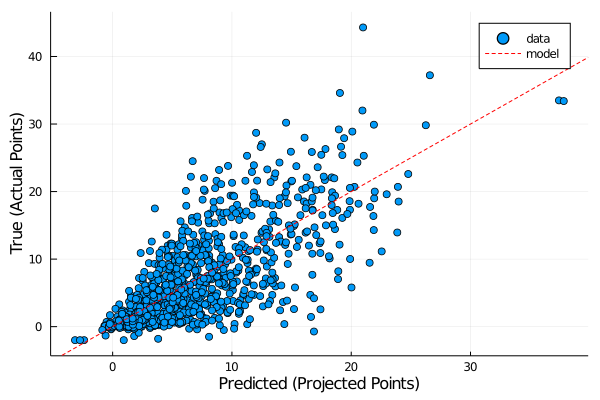

In [12]:
plot_pred_true(test_pred, test_std)

## OLS with GLM package
Use GLM package for OLS

In [13]:
Xtrain_glm = replace(hcat(convert(Matrix, train_real), train_cat_vals), NaN=>0)

42195×188 Array{Float64,2}:
   0.0    0.0      0.0       0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 198.0    0.0      0.0      25.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 274.125  2.125    1.25     38.875         0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
 218.267  1.53333  1.06667  28.8        …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  0.0  0.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0       0.0           0.0  

In [14]:
m = lm(Xtrain_glm[:, 1:97], train_std) # works with 97 variables;

In [15]:
lm(Xtrain_glm[:, 1:98], train_std) # doesn't work with 98 features because of multicollinearity

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

Use $\texttt{allowrankdeficient = true}$ to analytically solve some of the issues with multicollinearity.

In [16]:
m2 = lm(Xtrain_glm, train_std, true)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,CholeskyPivoted{Float64,Array{Float64,2}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────────────────
            Coef.    Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────
x1     0.0449176     0.0029501    15.23    <1e-51    0.0391353     0.0506998
x2     4.80255       0.149015     32.23    <1e-99    4.51048       5.09462
x3    -2.45474       0.147195    -16.68    <1e-61   -2.74325      -2.16624
x4    -0.0580173     0.0302686    -1.92    0.0553   -0.117344      0.00130982
x5     0.01319       0.0501344     0.26    0.7925   -0.0850745     0.111455
x6    -0.189716      0.020437     -9.28    <1e-19   -0.229773     -0.149659
x7     0.139441      0.00419163   33.27    <1e-99    0.131225      0.147657
x8     7.42001       0.168037     44.16    <1e-99    7.09065       7.74937
x9     0.0553478     0.0530618 

In [17]:
Xtest_glm = replace(hcat(convert(Matrix, test_real), test_cat_vals), NaN=>0)
pred_m2_test = predict(m2, Xtest_glm)
test_MSE = MSE(test_std, pred_m2_test)

20.225452341021192

Generic OLS with the first matrix (that has 198 rows) shows that some columns may be multicollinear, so we should consider how to resolve this multicollinearity. We can create a new matrix that takes out the multicollinear columns.

In [18]:
Xtrain_glm2 = hcat(Xtrain_glm[:,1:93], Xtrain_glm[:, 95:128], Xtrain_glm[:, 130:184]);

That allows us to calculate OLS with the typical algorithm.

In [19]:
m3 = lm(Xtrain_glm2, train_std);

In [20]:
pred_m3 = predict(m3, Xtrain_glm2);

In [21]:
Xtest_glm2 = hcat(Xtest_glm[:,1:93], Xtest_glm[:, 95:128], Xtest_glm[:, 130:184])
pred_m3_test = predict(m3, Xtest_glm2)
test_MSE = MSE(test_std, pred_m3_test)

20.225452341021185

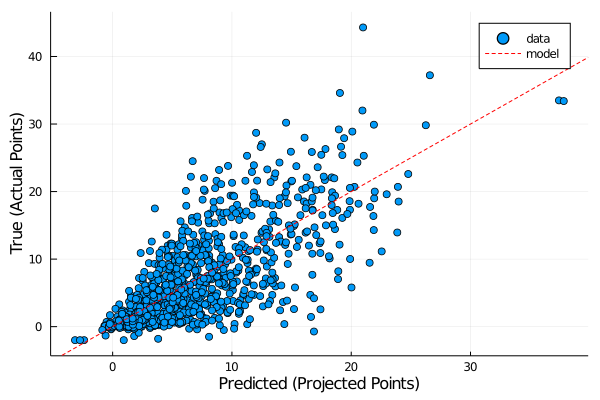

In [22]:
plot_pred_true(pred_m3_test, test_std)
# savefig("ols.png")

# Lasso Regression
## Lasso paths with Lasso.jl

In [23]:
m_lasso = fit(LassoPath, Xtrain_glm2, train_std, Normal())

LassoPath (86) solutions for 183 predictors in 3176 iterations):
───────────────────────────────────
               λ    pct_dev  ncoefs
───────────────────────────────────
 [1]  3.20194     0.0             0
 [2]  2.91749     0.0360114       1
 [3]  2.65831     0.0659086       1
 [4]  2.42215     0.0907299       1
 [5]  2.20697     0.123504        2
 [6]  2.01091     0.156755        2
 [7]  1.83227     0.198836        4
 [8]  1.66949     0.250555        5
 [9]  1.52118     0.303153        5
[10]  1.38604     0.348086        6
[11]  1.26291     0.385636        6
[12]  1.15072     0.416783        6
[13]  1.04849     0.442643        6
[14]  0.955346    0.464084        6
[15]  0.870476    0.481916        6
[16]  0.793145    0.496713        6
[17]  0.722684    0.509019        6
[18]  0.658483    0.519201        6
[19]  0.599985    0.52767         6
[20]  0.546684    0.534713        6
[21]  0.498118    0.540537        6
[22]  0.453867    0.545396        6
[23]  0.413546    0.549418        6

In [24]:
pred_m_lasso_test = predict(m_lasso, Xtest_glm2)[:, 85]
test_MSE_lasso = MSE(test_std, pred_m_lasso_test)

20.219661806443302

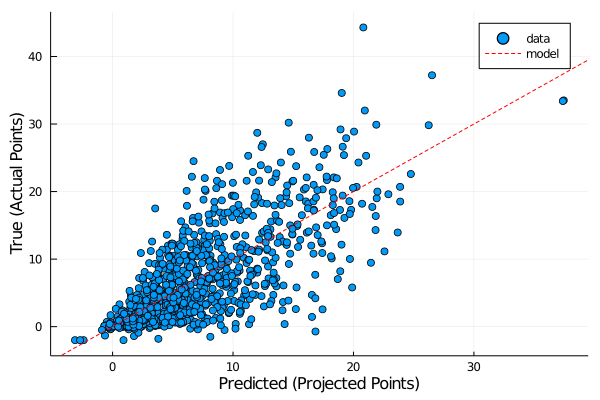

In [25]:
plot_pred_true(pred_m_lasso_test, test_std)
# savefig("lasso.png")

In [26]:
# plot(m_lasso; x = m_lasso[:, :logλ])

## Cross-validation procedure to select $\lambda$ for lasso regression

Train lasso model with 10-fold cross validation procedure.

In [27]:
Random.seed!(0)
lasso_cv = fit(LassoModel, Xtrain_glm, train_std; select = MinCVmse(Kfold(42195,10)), standardize = false, intercept = false);

Although we have 188 features in this feature matrix, the Lasso cross-validation generates a coefficient matrix that only uses 30 coefficients. 

In [28]:
pred_lasso_cv = predict(lasso_cv, Xtest_glm)

10550-element Array{Float64,1}:
 15.800988677730247
  2.759404630566293
  9.866249163018585
 10.694271493766795
 -0.05054835140526234
  4.9118843553323694
  1.603147136975993
  4.247950442501439
 18.629754145972218
  4.813016822597016
 20.130914325507984
 21.7645370919383
  1.543459866734801
  ⋮
  2.1712616846233828
  6.591486578755294
 12.145758551145477
  1.81768230603959
 14.901808458731818
 13.580531537980395
 15.025656028046917
  6.495659635369528
 15.286244265085706
  3.516814295053018
 10.979571745710455
  1.6118434258213674

In [29]:
lasso_cv_ppr = fit(LassoModel, Xtrain_glm, train_ppr; select = MinCVmse(Kfold(42195,10)), standardize = false, intercept = false)
pred_lasso_cv_ppr = predict(lasso_cv_ppr, Xtest_glm)
lasso_cv_half = fit(LassoModel, Xtrain_glm, train_half; select = MinCVmse(Kfold(42195,10)), standardize = false, intercept = false)
pred_lasso_cv_half = predict(lasso_cv_half, Xtest_glm);

In [30]:
test_MSE_lasso_cv = MSE(test_std, pred_lasso_cv)
test_MSE_lasso_ppr = MSE(test_ppr, pred_lasso_cv_ppr)
test_MSE_lasso_half = MSE(test_half, pred_lasso_cv_half);

@show test_MSE_lasso_cv;
@show test_MSE_lasso_ppr;
@show test_MSE_lasso_half;

test_MSE_lasso_cv = 20.65260564655604
test_MSE_lasso_ppr = 27.50530957071072
test_MSE_lasso_half = 23.64414027706626


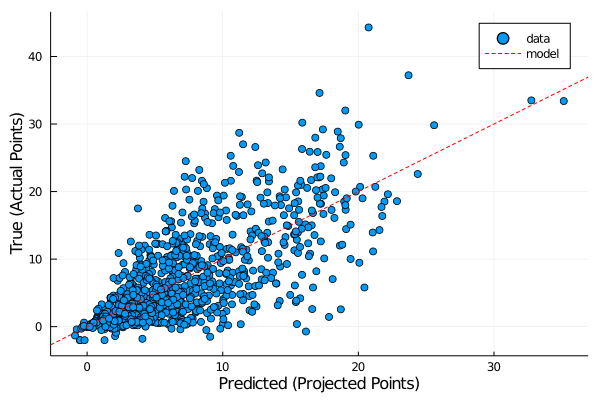

In [31]:
plot_pred_true(pred_lasso_cv, test_std)

Create dataframe of all data.

In [32]:
Xtrain_df = DataFrame(Xtrain_glm)
Xtrain_df.Y = train_std
Xtrain_df;

## Export

Export linear predictions as a .csv for use in projections.

In [33]:
test_pred_all = DataFrame(std_lasso = pred_lasso_cv, ppr_lasso = pred_lasso_cv_ppr, half_lasso = pred_lasso_cv_half)
# CSV.write("$(pwd())\\test_pred.csv", test_pred_all)

,std_lasso,ppr_lasso,half_lasso
,Float64,Float64,Float64
1,15.801,15.9087,15.8553
2,2.7594,4.77035,3.78934
3,9.86625,10.0567,10.0122
4,10.6943,14.3002,12.4515
5,-0.0505484,0.927129,0.44758
6,4.91188,8.49866,6.66692
7,1.60315,3.41625,2.43659
8,4.24795,5.04232,4.66932
9,18.6298,18.623,18.6345


In [34]:
df_x = df[:, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
df_real = df_x[:, labels_real]
df_cats = hcat([onehot(df_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
df_matrix = replace(hcat(convert(Matrix, df_real), df_cats), NaN=>0)
points_pred_lm = predict(m2, df_matrix)
points_pred_lasso = predict(lasso_cv, df_matrix);

In [35]:
df_points = df[:, 1:4]
df_points.std_lm = points_pred_lm
df_points.std_lasso = points_pred_lasso
df_points.season = df[:, 24]
df_points

,week,Player,Pos,team1,std_lm,std_lasso,season
,Int64,String,String,String,Float64,Float64,Int64
1,13,Daryl Richardson,RB,STL,5.07783,5.63167,2012
2,13,Bennie Fowler,WR,DEN,3.82342,3.91123,2017
3,13,Adrian Peterson,RB,MIN,14.9103,14.4756,2009
4,10,Allen Robinson,WR,JAX,12.5669,12.0449,2015
5,2,Luke Falk,QB,NYJ,8.98075,9.42648,2019
6,16,Kendall Hunter,RB,SFO,4.96679,5.26702,2011
7,3,Preston Parker,WR,TAM,3.80491,4.26893,2011
8,9,Blake Bortles,QB,JAX,19.5325,19.6558,2015
9,12,Randall Cobb,WR,GNB,3.35989,3.72249,2011


In [36]:
# CSV.write("$(pwd())\\projections_2019\\points_proj.csv", df_points)